In [178]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L
from scipy.integrate import solve_ivp as solve

To save time and space anytime rho appears without a specific mention of an element of rho (like rhogg), rho will be defined as rho = [rhogg, rhoee, rhoge]. As such, when we have multiple harmonic osc states, rho[n] = [rhogg, rhoee, rhoge] and rho = [rho[0], rho[1] ...]

Update: we need rho to be 1D to be compatible with the integrater. So now rhoggn = rho[3n], rhoeen = rho[3n+1], and rhogen = rho[3n+2]

In [258]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def dopAndStark(n):       #for 1D!! to make 3d, multiply this by 3                        
    return -2.0*np.pi*nu0*hbar*omega*(n+0.5)/(m*c**2)*(1.0 + alpha*m**2*Omegarf**2*c**2/(h*nu0*e**2*2)) 

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [334]:
#def groundRho(Ncut):
#    rho = np.array([[0.0+0.0j]*3]*(Ncut+1))
#    rho[0][0] = 1.0+0.0j
#    rho = np.reshape(rho, (Ncut+1)*3)
#    return rho

#def groundRho(Ncut):
#    rho = np.array([[0.0j, 0.0j], [0.0j, 0.0j]]*(Ncut+1))
#    #rho[0][0] = 1.0+0.0j
#    #rho = np.reshape(rho, (Ncut+1)*3)
#    return rho

def groundRho(Ncut, nbar):
    rho = np.zeros([Ncut+1,2,2],dtype=np.complex_)
    for n in range(Ncut+1):
        rho[n][0][0] = prob(n,nbar)
    return rho

def pulseSys(t, rho, Omega, delta):
    rhogg, rhoee, rhoge = rho
    rhoeg = np.conj(rhoge)
    rhoggDot = 1j*Omega/2.0*(rhoge - rhoeg)
    rhoeeDot = -1j*Omega/2.0*(rhoge - rhoeg)
    rhogeDot = -1j*Omega/2.0*(rhoee - rhogg) - 1.0j*delta*rhoge
    return [rhoggDot, rhoeeDot, rhogeDot]

#def heatSys(t, rho, nbardot):
#    Ncut = rho.shape[0]//3 - 1
#    rhoDot = [0.0+0.0j]*((Ncut+1)*3)
#    for ii in range(3):
#        rhoDot[0+ii] = nbardot*(-rho[0+ii]+rho[3*1+ii])
#        rhoDot[3*Ncut+ii] = nbardot*(-Ncut*rho[3*Ncut+ii]+Ncut*rho[3*(Ncut-1)+ii])
#        #Note*** the above line is true in the limit that rho[Ncut+1,ii]=rho[Ncut,ii] (fair assumption for large Ncut I think)
#        for n in range(1,Ncut-1):
#            rhoDot[3*n+ii] = nbardot*(-(2.0*n+1.0)*rho[3*n+ii] + (n+1.0)*rho[3*(n+1)+ii] + n*rho[3*(n-1)+ii])
#    return rhoDot

def heatSys(t, rho, nbardot):    #takes rho as a 2x2x(Ncut+1) matrix
    Ncut = rho.size//4 - 1
    rhoDot = [0.0+0.0j]*((Ncut+1)*4)
    rho = np.reshape(rho, (Ncut+1)*4)
    for ii in range(3):
        rhoDot[0+ii] = nbardot*(-rho[0+ii]+rho[4*1+ii])
        rhoDot[4*Ncut+ii] = nbardot*(-Ncut*rho[4*Ncut+ii]+Ncut*rho[4*(Ncut-1)+ii])
        #Note*** the above line is true in the limit that rho[Ncut+1,ii]=rho[Ncut,ii] (fair assumption for large Ncut I think)
        for n in range(1,Ncut-1):
            rhoDot[4*n+ii] = nbardot*(-(2.0*n+1.0)*rho[4*n+ii] + (n+1.0)*rho[4*(n+1)+ii] + n*rho[4*(n-1)+ii])
    return rhoDot

def freeEvo(t, rho0, delta):
    rhoge0 = rho0[2]
    rho = [rho0[0], rho0[1], rhoge0*np.exp(-1.0j*delta*t)]
    return rho

#def nbar(rho):
#    Ncut = rho.shape[0]//3
#    nbar = 0.0
#    for n in range(Ncut):
#        nbar += n*(rho[n*3].real + rho[n*3+1].real)
#    return nbar

def nbar(rho):
    Ncut = np.shape(rho)[0]
    nbar = 0.0
    for n in range(Ncut):
        nbar += n*(np.real(rho[n][0][0]) + np.real(rho[n][1][1]))
    return nbar

In [342]:
### ---Integration of the optical bloch equations--- ###
#def subpulse(rho0, t, Omega0, delta):
#    rho = solve(pulseSys, [0.0,t], rho0, args=[Omega0, delta]).y[:,-1]
#    return rho

#def pulse(rho0, t, Omega0, delta):
#    Ncut = rho0.shape[0]//3 - 1
#    rho = np.array([0.0j, 0.0j, 0.0j]*(Ncut+1))
#    for n in range(Ncut):
#        rho[3*n:3*n+3] = subpulse(rho0[3*n:3*n+3], t, Omega0, delta)
#    return rho
### ------------------------------------------------- ###
def heat(rho, t, nbardot):
    Ncut = rho.size//4 - 1
    rho = np.reshape(rho, (Ncut+1)*4)
    rho = solve(heatSys, [0.0,t], rho, args=[nbardot]).y[:,-1]
    
    return np.reshape(rho, [2,2,Ncut+1])

def ramsey(rho0, T, deld, delPrime, Omega0):
    #T = dark-time, deld = dark-time detuning, delPrime=pulse detuning
    rho = solve(bloch, [0.0, np.pi/(2.0*Omega0)], rho0, args=(Omega0, delPrime)).y[:,-1]
    rho = freeEvo(T, rho, deld)
    rho = solve(bloch, [0.0, np.pi/(2.0*Omega0)], rho, args=(Omega0, delPrime)).y[:,-1]
    return rho

In [314]:
def subpulse(rho, t, Omega0, delta):
    Omega = np.sqrt(Omega0**2 + delta**2)
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    return U@rho@np.conj(U)

def pulse(rho, t, Omega0, delta, eta):
    Ncut = rho.size//4 -1
    for n in range(Ncut):
        rho[n] = subpulse(rho[n], t, Omega0*Omega(n,0,eta), delta)
    return rho

In [293]:
rho0 = np.array([[1.0+0.0j, 0.0j],[0.0j, 0.0j]])
densPulse(rho0, 1.0, np.pi/2.0, 0.0)

array([[0.5+0.j , 0. -0.5j],
       [0. +0.5j, 0.5+0.j ]])

In [299]:
subpulse(np.array([1.0+0.0j, 0.0j, 0.0j]), 1.0, np.pi/2.0, 0.0)

array([0.49996497+0.j        , 0.50003503+0.j        ,
       0.        +0.49998591j])

In [247]:
a = heat(groundRho(1000), 2.0,  2.0)
#solve(heatSys, [0.0,1.0], groundRho(2), args=[1.0])

In [287]:
nbar(rho)

0.0

C:\Users\Mark\AppData\Local\Temp\ipykernel_19980\2492409076.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  rhoees[ii] = ramsey(groundRho(), T, deld, deltas[ii]-shift, 1.0)[1]
C:\Users\Mark\AppData\Local\Temp\ipykernel_19980\2492409076.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  rhoggs[ii] = ramsey(groundRho(), T, deld, deltas[ii]-shift, 1.0)[0]


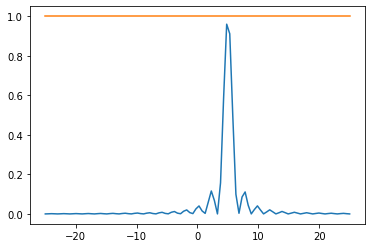

In [101]:
pts = 100
deltas = np.linspace(-25.0, 25.0, pts)
rhoees = np.zeros(pts)
rhoggs = np.zeros(pts)
shift = 5.0
T = 1.0
deld = 0.0

for ii in range(pts):
    rhoees[ii] = ramsey(groundRho(), T, deld, deltas[ii]-shift, 1.0)[1]
    rhoggs[ii] = ramsey(groundRho(), T, deld, deltas[ii]-shift, 1.0)[0]

    
plt.plot(deltas, rhoees)
plt.plot(deltas, rhoees+rhoggs)

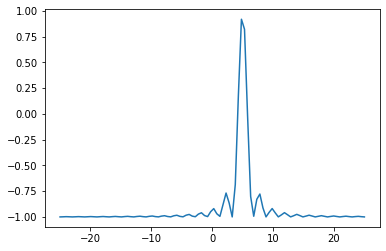

In [103]:
plt.plot(deltas,rhoees-rhoggs)

In [104]:
sol = solve(bloch, [0,10], [1.0+0.0j,0.0+0.0j,0.0+0.0j], args=(np.pi, 0.0))#, dense_output=True)

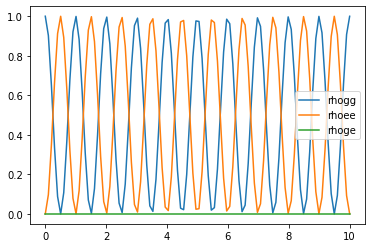

In [54]:
t = np.linspace(0,10,100)
z = sol.sol(t)
plt.plot(t, z.T)
plt.legend(['rhogg','rhoee','rhoge'])

In [77]:
sol.y[:,-1]

array([9.99768742e-01+0.j        , 2.31257740e-04+0.j        ,
       0.00000000e+00+0.00854519j])

In [105]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 278
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 6.35983789e-04, 6.99582167e-03, 7.05942005e-02,
       3.12286503e-01, 6.32292515e-01, 9.60536933e-01, 1.25710575e+00,
       1.54706797e+00, 1.87795848e+00, 2.09764757e+00, 2.31426666e+00,
       2.63530708e+00, 2.96337509e+00, 3.25901332e+00, 3.55041738e+00,
       3.88125792e+00, 4.10504339e+00, 4.31941604e+00, 4.64100642e+00,
       4.93499683e+00, 5.22898724e+00, 5.50539024e+00, 5.83641961e+00,
       6.06591975e+00, 6.29541989e+00, 6.61338124e+00, 6.94233012e+00,
       7.24332607e+00, 7.52601569e+00, 7.85705226e+00, 8.09792339e+00,
       8.32249495e+00, 8.64475985e+00, 8.93748226e+00, 9.23020468e+00,
       9.50819448e+00, 9.83924750e+00, 1.00000000e+01])
 t_events: None
        y: array([[1.00000000e+00+0.j        , 9.99999002e-01+0.j        ,
        9.99879246e-01+0.j        ,

In [119]:
rhos = np.array([[0.333,1,0],[0.333,2,0],[0.333,3,0.0],[0.0,0.0,0.0]])

In [117]:
rhos[2,1]

3.0

In [115]:
rhos.shape[0]

4

In [121]:
np.array([[0.0+0.0j]*3]*4)

array([[0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j]])

In [126]:
for ii in range(3):
    print(ii)

0
1
2


array([[1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j]])

In [143]:
solve(heatSys, [0.0,1.0], groundRho(2), args=(1.0))

TypeError: Value after * must be an iterable, not float

In [185]:
groundRho(2).shape[0]//3

2

In [218]:
groundRho(2)

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j])

In [157]:
2*3

6

In [161]:
np.array([0.0+0.0j]*(2*3))

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [195]:
a = [0.0+0.0j]*(1*3)

In [198]:
a[1] = groundRho(2)[0]

In [199]:
a

[0j, (1+0j), 0j]

In [227]:
a = 1.0+2.0j

In [228]:
a.real

1.0

In [237]:
for ii in range(2):
    print(ii)

0
1


In [290]:
np.array([[1,2],[3,4]])

array([[1, 2],
       [3, 4]])

In [292]:
np.zeros([2,2])

array([[0., 0.],
       [0., 0.]])

In [311]:
groundRho(2,0.0)

array([[[1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]]])

In [315]:
pulse(groundRho(2,0.0), 1.0, np.pi/2.0, 0.0, 0.0)

array([[[0.5+0.j , 0. -0.5j],
        [0. +0.5j, 0.5+0.j ]],

       [[0. +0.j , 0. +0.j ],
        [0. +0.j , 0. +0.j ]],

       [[0. +0.j , 0. +0.j ],
        [0. +0.j , 0. +0.j ]]])

In [345]:
rho = heat(groundRho(1000,1.0), 1.0,1.0)

In [331]:
np.reshape(groundRho(3,1.0), (3+1)*4).size

16

In [337]:
nbar(groundRho(100,1.0))

0.9999999999999999

In [346]:
nbar(rho)

2.281507747080369e-205

array([0.33333092+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.22220454+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.14807707+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.09855808+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.0653449 +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.04287914+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.02734729+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.01631091+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.0078559 +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.00097656+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.00097654+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j])